# Field Inventory Analysis

Objective

1. Create a periodic snapshot of recreational boat engine inventory level
2. Analyse the field pipeline inventory and velocity (from the day of the wholesale to retail sales)

In [7]:
class field_inventory_estimator:
    import pandas as pd
    import seaborn as sns
    from threading import Thread
    import matplotlib.pyplot as plt

    date_range = None
    data = pd.DataFrame()
    data_modified = pd.DataFrame()
    who_ret_combined = pd.DataFrame()
    dict_list_snapshot = []
    snapshot = None

    
    def __init__(self):
        import warnings
        warnings.filterwarnings('ignore')
        
        self.data = self.pd.read_csv('data.csv')
        data_modified = self.pd.DataFrame()
        data_modified = self.fix_date_format(self.data)
        self.who_ret_combined = self.get_who_ret_combined(data_modified)

    
    def fix_date_format(self, data):
        df = data

        df['CALENDAR_DATE'] = self.pd.to_datetime(df['CALENDAR_DATE'])
        df['OE_SALES_DATE_str'] = df['OE_SALES_DATE'].astype('str')

        df['OE_SALES_YEAR'] = df['CALENDAR_DATE'].dt.year
        df['OE_SALES_MONTH'] = df['CALENDAR_DATE'].dt.month
        
        f_length_8 = df['OE_SALES_DATE_str'].str.len() == 8
        f_length_9 = df['OE_SALES_DATE_str'].str.len() == 9
        f_length_10 = df['OE_SALES_DATE_str'].str.len() == 10
        f_date_gt_20000000 = df['OE_SALES_DATE_str'].astype(float) >= 20000000
        f_date_lt_20000000 = df['OE_SALES_DATE_str'].astype(float) < 20000000
        month_oct_dec = df['OE_SALES_MONTH'].isin([10,11,12])

        df.loc[f_length_8,'OE_SALES_DAY'] = df.loc[f_length_8 ,'OE_SALES_DATE_str'].str[1:2]

        df.loc[f_length_9&month_oct_dec,'OE_SALES_DAY'] = \
            df.loc[f_length_9&month_oct_dec ,'OE_SALES_DATE_str'].str[2:3]

        df.loc[f_length_9&~(month_oct_dec),'OE_SALES_DAY'] = \
            df.loc[f_length_9&~(month_oct_dec) ,'OE_SALES_DATE_str'].str[1:3]

        df.loc[(f_length_10) & (f_date_gt_20000000),'OE_SALES_DAY'] = \
            df.loc[(f_length_10) & (f_date_gt_20000000),'OE_SALES_DATE_str'].str[6:8]

        df.loc[(f_length_10) & (f_date_lt_20000000),'OE_SALES_DAY'] = \
            df.loc[(f_length_10) & (f_date_lt_20000000),'OE_SALES_DATE_str'].str[2:4]

        df['OE_SALES_YEAR'].dtype
        df['OE_SALES_MONTH'].dtype
        df['OE_SALES_DAY'] = df['OE_SALES_DAY'].astype('int64')
        df.loc[(df['OE_SALES_DAY'] >= 30)&(df['OE_SALES_MONTH'] == 2),'OE_SALES_DAY'] = 28

        time_df = df[['OE_SALES_YEAR','OE_SALES_MONTH','OE_SALES_DAY']]
        time_df.columns = ['year','month','day']

        df['OE_SALES_DATE_MOD'] = self.pd.to_datetime(time_df,format='%Y-%m-%d')
        df = df[(df['OE_SALES_DATE_MOD']>='2008-01-01')]
        
        return df


    def get_who_ret_combined(self, data):
        df = data
        
        wholesale = df[(df['SALES_RETURNS'] == 'SALES')&(df['OE_SALE_TYPE'] != 'Retail sale')]
        retail = df[(df['SALES_RETURNS'] == 'SALES')&(df['OE_SALE_TYPE'] == 'Retail sale')]

        wholesale['SALE_DATE_RANK'] = wholesale.loc[:,['OE_SERIAL_NUMBER','OE_SALES_DATE_MOD']].\
                groupby('OE_SERIAL_NUMBER').rank('dense').iloc[:,0]
        retail['SALE_DATE_RANK'] = retail[['OE_SERIAL_NUMBER','OE_SALES_DATE_MOD']].\
                groupby('OE_SERIAL_NUMBER').rank(method = 'dense', ascending = False).iloc[:,0]

        oldest_wholesale = wholesale.loc[wholesale['SALE_DATE_RANK'] == 1, \
                    ['OE_SERIAL_NUMBER','OE_SALE_TYPE','NEW_BREAKDOWN','SALES_RETURNS','OE_SALES_DATE_MOD']]
        latest_retail = retail.loc[retail['SALE_DATE_RANK'] == 1, \
                    ['OE_SERIAL_NUMBER','OE_SALE_TYPE','NEW_BREAKDOWN','SALES_RETURNS','OE_SALES_DATE_MOD']]   
        
        who_ret_combined = oldest_wholesale.merge(latest_retail, left_on = 'OE_SERIAL_NUMBER'\
                                                      , right_on = 'OE_SERIAL_NUMBER', how = 'left')

        who_ret_combined = who_ret_combined.drop(who_ret_combined[who_ret_combined['OE_SALES_DATE_MOD_x']>\
                                                 who_ret_combined['OE_SALES_DATE_MOD_y']].index)

        return who_ret_combined


    def get_date_range(self, data):
        df = data
        
        _list = list()
        
        date = (df.loc[df['OE_SALE_TYPE'] != 'Retail sale','CALENDAR_DATE'].min()\
                    + self.pd.DateOffset(months=35))\
                    + self.pd.offsets.MonthEnd(0)
        # date = self.pd.to_datetime('2023-01-01')
        date_36 = (date+self.pd.DateOffset(months=-36))\
                    + self.pd.offsets.MonthBegin(0)
        date_max = df.loc[df['OE_SALE_TYPE'] != 'Retail sale','CALENDAR_DATE'].max().floor('d')\
                    + self.pd.offsets.MonthEnd(0)    
        
        while date <= date_max:
            _list.append([date_36, date])
            date = (date + self.pd.DateOffset(months=1)).floor('d')\
                    + self.pd.offsets.MonthEnd(0)
            date_36 = (date + self.pd.DateOffset(months=-36)).floor('d')\
                    + self.pd.offsets.MonthBegin(0)
            

        return _list


    def get_snapshot(self, data, date_36, date):
        who_ret_combined = data
        date_36 = date_36
        date = date
        
        df_windowed = who_ret_combined[(who_ret_combined['OE_SALES_DATE_MOD_x'] >= date_36) \
                            & (who_ret_combined['OE_SALES_DATE_MOD_x'] <= date)]
        
        df_windowed.loc[(df_windowed['OE_SALES_DATE_MOD_y'].isnull()),'IN_PIPELINE'] = 1
        df_windowed.loc[(df_windowed['OE_SALES_DATE_MOD_y']>=date),'IN_PIPELINE'] = 1

        df_windowed.loc[(df_windowed['IN_PIPELINE'].isnull()),'IN_PIPELINE'] = 0
        
        df_windowed.loc[(df_windowed['IN_PIPELINE']==0),'PIPELINE_LENGTH'] =\
                df_windowed['OE_SALES_DATE_MOD_y'] - df_windowed['OE_SALES_DATE_MOD_x']  
        
        df_windowed['SNAPSHOT_DATE'] = date
        
        df_windowed['PIPELINE_LENGTH'] = df_windowed['PIPELINE_LENGTH'].dt.days
        
        self.snapshot = self.pd.concat([self.snapshot,df_windowed])     


    def draw_trends(self, data):
        df = data
        
        data = df.loc[(df['SNAPSHOT_DATE']>='2018-01-01'),['SNAPSHOT_DATE','NEW_BREAKDOWN_x','IN_PIPELINE']]\
                .groupby(['SNAPSHOT_DATE','NEW_BREAKDOWN_x']).sum('IN_PIPELINE').reset_index()
        data['NEW_BREAKDOWN_x'] = self.pd.Categorical(data['NEW_BREAKDOWN_x']\
                                                ,['0 - 3.9 hp', '4 - 9.9 hp', '10 - 29.9 hp', '30 - 49.9 hp'\
                                                , '50 - 74.9 hp','75 - 99.9 hp', '100 - 149.9 hp', '150 - 199.9 hp'\
                                                ,'200 - 249.9 hp', '250 - 299.9 hp', '300 - 349.9 hp', '350 hp and over'])
        
        g = self.sns.FacetGrid(data, col='NEW_BREAKDOWN_x', col_wrap=4)
        
        g.map(self.sns.lineplot,'SNAPSHOT_DATE','IN_PIPELINE')
        self.plt.show()


    def draw_heatmap(self, data):
        df = data
        
        data = df.loc[(df['SNAPSHOT_DATE']>='2019-01-01'),['SNAPSHOT_DATE','NEW_BREAKDOWN_x','PIPELINE_LENGTH']]\
                 .groupby(['SNAPSHOT_DATE','NEW_BREAKDOWN_x']).median('PIPELINE_LENGTH').reset_index()\
                 .pivot(index='SNAPSHOT_DATE',columns='NEW_BREAKDOWN_x',values='PIPELINE_LENGTH')
        
        data.index = data.index.strftime('%Y-%m-%d')
        
        data = data[['0 - 3.9 hp', '4 - 9.9 hp', '10 - 29.9 hp', '30 - 49.9 hp', '50 - 74.9 hp','75 - 99.9 hp'\
                     , '100 - 149.9 hp', '150 - 199.9 hp','200 - 249.9 hp', '250 - 299.9 hp', '300 - 349.9 hp', '350 hp and over']]
        
        self.sns.heatmap(data.transpose())
        self.plt.show()

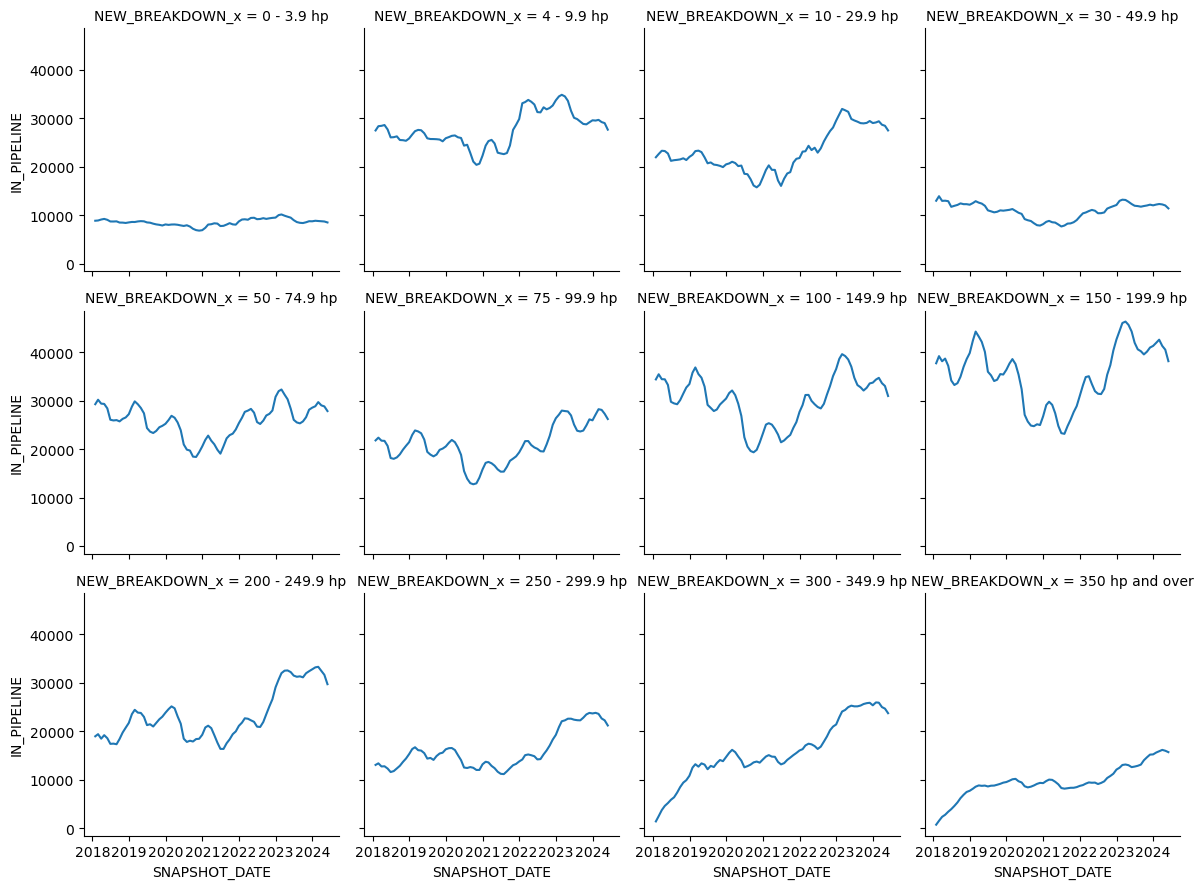

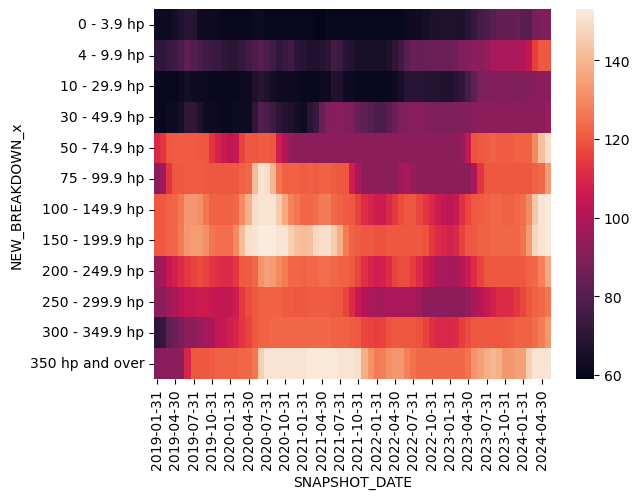

It took 993.76 second(s) to complete.


In [8]:
def main():
    from threading import Thread
    from IPython.display import display, Markdown
    import warnings
    warnings.filterwarnings('ignore')

    estimator = field_inventory_estimator()
    estimator.date_range = estimator.get_date_range(estimator.data)
    
     # create threads
    threads = [Thread(target=estimator.get_snapshot\
                      , args=(estimator.who_ret_combined, _range[0], _range[1]))
            for _range in estimator.date_range]

    # start the threads
    for thread in threads:
        thread.start()
        thread.join()

    estimator.draw_trends(estimator.snapshot)
    estimator.draw_heatmap(estimator.snapshot)

if __name__ == "__main__":
    from time import perf_counter
    start_time = perf_counter()
    
    main()

    end_time = perf_counter()
    print(f'It took {end_time- start_time :0.2f} second(s) to complete.')

## Analysis

From the graphs above, we could find out:

1. Mid-size engines(50hp to 200hp) ran into low inventory during pademic period, while small and big engines had steady flow.
2. Coming out of pandemic, the engines are staying in the pipeline longer overall. 